Ban đầu: rows=1781, cols=19
Loại Qoil<=0: 12 hàng
IQR filter: loại 58 hàng; bounds=(12.31, 128.02)
IsolationForest: loại 18 hàng (cols: 18)
Kết quả: giữ lại 1693 hàng; đã loại 88 hàng
Saved: /content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv /content/drive/MyDrive/Dữ liệu/BK_20_Test_3_removed.csv


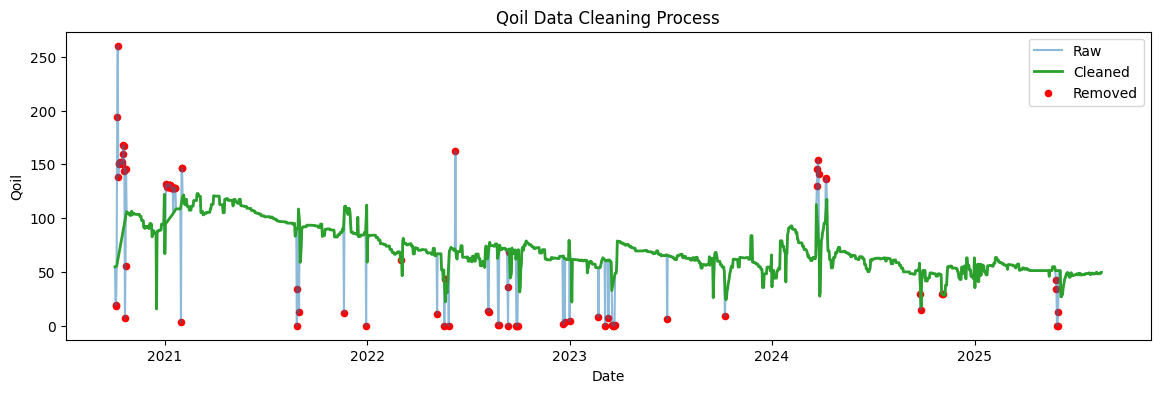

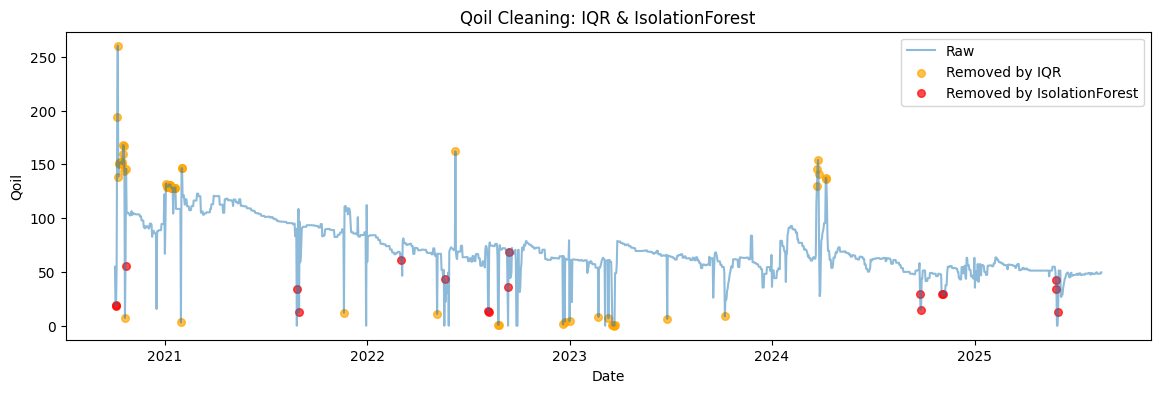

Plots saved in: /content/drive/MyDrive/Dữ liệu/plots


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import os

def clean_qoil_data(
    df,
    date_col="Date",
    target="Qoil",
    replace_spikes=False,
    spike_window=5,
    spike_std_thresh=3.0,
    iqr_k=1.5,
    if_contamination="auto",
    if_numeric_cols=None,
    random_state=42,
    verbose=True,
):
    df = df.copy()

    # Sort theo ngày (nếu có)
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
        df = df.sort_values(by=date_col).reset_index(drop=True)

    if verbose:
        print(f"Ban đầu: rows={len(df)}, cols={len(df.columns)}")

    df = df.ffill().bfill()  # xử lý missing

    removed_list = []

    # Loại bỏ Qoil <= 0
    mask_zero = (df[target] <= 0) | (df[target].isna())
    if mask_zero.any():
        tmp = df.loc[mask_zero].copy()
        tmp["_reason"] = "Qoil_zero_or_negative"
        removed_list.append(tmp)
        df = df.loc[~mask_zero].copy()
        if verbose:
            print(f"Loại Qoil<=0: {len(tmp)} hàng")

    # Thay spike đơn điểm (tuỳ chọn)
    if replace_spikes:
        s = df[target]
        rolling_med = s.rolling(window=spike_window, center=True, min_periods=1).median()
        rolling_std = s.rolling(window=spike_window, center=True, min_periods=1).std().fillna(0)
        spike_mask = (s - rolling_med).abs() > (spike_std_thresh * rolling_std)
        if spike_mask.any():
            tmp = df.loc[spike_mask].copy()
            tmp["_reason"] = "Spike_replaced_rolling_median"
            removed_list.append(tmp)
            df.loc[spike_mask, target] = rolling_med.loc[spike_mask]
            if verbose:
                print(f"Thay spike bằng median: {spike_mask.sum()} điểm (window={spike_window})")

    # IQR filter (univariate)
    if iqr_k:
        q1, q3 = df[target].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - iqr_k * iqr, q3 + iqr_k * iqr
        mask_iqr = (df[target] < lower) | (df[target] > upper)
        if mask_iqr.any():
            tmp = df.loc[mask_iqr].copy()
            tmp["_reason"] = f"IQR_k_{iqr_k}"
            removed_list.append(tmp)
            df = df.loc[~mask_iqr].copy()
            if verbose:
                print(f"IQR filter: loại {mask_iqr.sum()} hàng; bounds=({lower:.2f}, {upper:.2f})")

    # IsolationForest (multivariate)
    if if_contamination is not None:
        numeric_cols = (
            if_numeric_cols or df.select_dtypes(include=[np.number]).columns.tolist()
        )
        if target not in numeric_cols:
            numeric_cols.append(target)

        X = df[numeric_cols].values
        Xs = StandardScaler().fit_transform(X)

        iso = IsolationForest(
            n_estimators=200, contamination=if_contamination, random_state=random_state
        )
        mask_if = iso.fit_predict(Xs) == -1
        if mask_if.any():
            tmp = df.loc[mask_if].copy()
            tmp["_reason"] = f"IsolationForest_cont_{if_contamination}"
            removed_list.append(tmp)
            df = df.loc[~mask_if].copy()
            if verbose:
                print(f"IsolationForest: loại {mask_if.sum()} hàng (cols: {len(numeric_cols)})")

    # Tổng hợp removed rows
    df_removed = (
        pd.concat(removed_list, axis=0).loc[lambda x: ~x.index.duplicated()]
        if removed_list
        else pd.DataFrame(columns=df.columns.tolist() + ["_reason"])
    )

    if verbose:
        print(f"Kết quả: giữ lại {len(df)} hàng; đã loại {len(df_removed)} hàng")

    return df.reset_index(drop=True), df_removed.reset_index(drop=True)


def plot_cleaning_process(df_raw, df_clean, df_removed, date_col="Date", target="Qoil", out_dir=None):
    """Plot toàn bộ quá trình clean"""
    for d in [df_raw, df_clean, df_removed]:
        d[date_col] = pd.to_datetime(d[date_col], dayfirst=True, errors="coerce")

    plt.figure(figsize=(14, 4))
    plt.plot(df_raw[date_col], df_raw[target], label="Raw", alpha=0.5, color="tab:blue")
    plt.plot(df_clean[date_col], df_clean[target], label="Cleaned", linewidth=2, color="tab:green")
    if not df_removed.empty:
        plt.scatter(df_removed[date_col], df_removed[target], c="red", s=20, label="Removed")
    plt.title("Qoil Data Cleaning Process")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    if out_dir:
        plt.savefig(f"{out_dir}/cleaning_process.png", bbox_inches="tight", dpi=150)
    plt.show()


def plot_iqr_if_process(df_raw, df_removed, date_col="Date", target="Qoil", out_dir=None):
    """Plot riêng các điểm bị loại bởi IQR và IsolationForest"""
    df_raw[date_col] = pd.to_datetime(df_raw[date_col], dayfirst=True, errors="coerce")
    plt.figure(figsize=(14, 4))
    plt.plot(df_raw[date_col], df_raw[target], label="Raw", alpha=0.5, color="tab:blue")

    # IQR
    df_iqr = df_removed[df_removed["_reason"].str.contains("IQR")]
    if not df_iqr.empty:
        plt.scatter(df_iqr[date_col], df_iqr[target], c="orange", s=30, label="Removed by IQR", alpha=0.7)

    # IsolationForest
    df_if = df_removed[df_removed["_reason"].str.contains("IsolationForest")]
    if not df_if.empty:
        plt.scatter(df_if[date_col], df_if[target], c="red", s=30, label="Removed by IsolationForest", alpha=0.7)

    plt.title(f"{target} Cleaning: IQR & IsolationForest")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    if out_dir:
        plt.savefig(f"{out_dir}/{target}_iqr_if_process.png", bbox_inches="tight", dpi=150)
    plt.show()

if __name__ == "__main__":
    # Setup input/output
    input_path = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3.csv"
    out_clean = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
    out_removed = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_removed.csv"
    out_plots = "/content/drive/MyDrive/Dữ liệu/plots"

    if not os.path.exists(out_plots):
        os.makedirs(out_plots)

    # Load raw data
    df_raw = pd.read_csv(input_path)

    # Clean data
    df_clean, df_removed = clean_qoil_data(
        df_raw,
        date_col="Date",
        target="Qoil",
        replace_spikes=True,
        spike_window=5,
        spike_std_thresh=3.0,
        iqr_k=1.5,
        if_contamination=0.01,
        if_numeric_cols=None,
        verbose=True,
    )

    # Save outputs
    df_clean.to_csv(out_clean, index=False)
    df_removed.to_csv(out_removed, index=False)
    print("Saved:", out_clean, out_removed)

    # Plot toàn bộ quá trình clean
    plot_cleaning_process(df_raw, df_clean, df_removed, out_dir=out_plots)
    # Plot riêng IQR và IsolationForest
    plot_iqr_if_process(df_raw, df_removed, out_dir=out_plots)
    print("Plots saved in:", out_plots)


Initial rows: 1781
Hard filter removed: 140
Spike replaced: 37
Rolling IQR removed: 104
IsolationForest removed: 31
Final kept rows: 1506
Total removed/replaced: 305


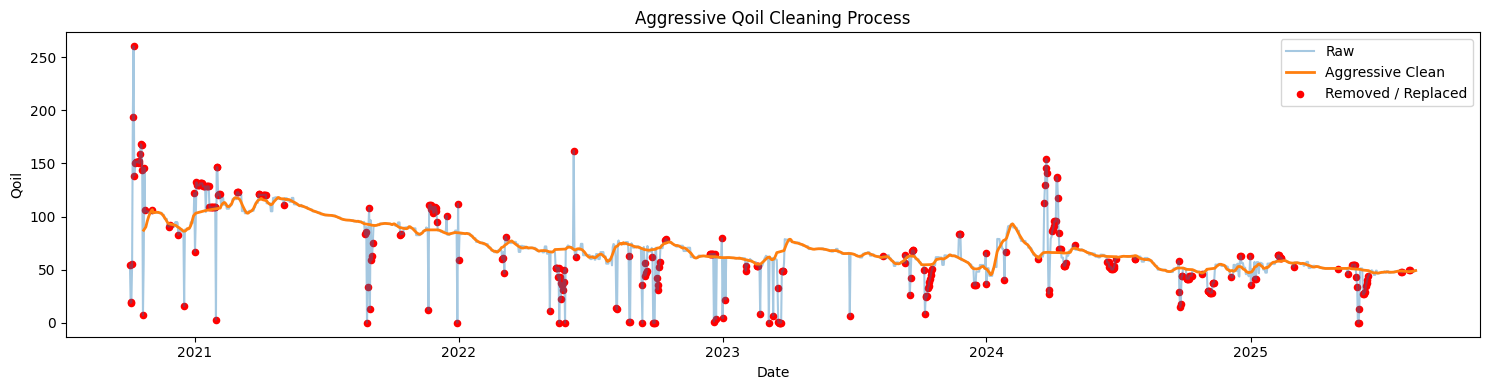

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import os

# ======================================================
# AGGRESSIVE QOIL CLEANING
# ======================================================
def clean_qoil_data_aggressive(
    df,
    date_col="Date",
    target="Qoil",
    hard_quantile_low=0.05,
    hard_quantile_high=0.97,
    spike_window=11,
    spike_std_thresh=2.0,
    rolling_iqr_window=60,
    iqr_k=0.8,
    if_contamination=0.02,
    if_numeric_cols=None,
    smooth_window=21,
    smooth_poly=2,
    random_state=42,
    verbose=True,
):
    df = df.copy()

    # --------------------------------------------------
    # Sort theo thời gian
    # --------------------------------------------------
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
    df = df.sort_values(date_col).reset_index(drop=True)

    if verbose:
        print(f"Initial rows: {len(df)}")

    # --------------------------------------------------
    # Fill missing
    # --------------------------------------------------
    df = df.ffill().bfill()

    removed = []

    # --------------------------------------------------
    # TIER 1 – HARD FILTER (CỰC MẠNH)
    # --------------------------------------------------
    q_low = df[target].quantile(hard_quantile_low)
    q_high = df[target].quantile(hard_quantile_high)

    mask_hard = (df[target] <= 0) | (df[target] < q_low) | (df[target] > q_high)
    if mask_hard.any():
        tmp = df.loc[mask_hard].copy()
        tmp["_reason"] = "Hard_quantile_cut"
        removed.append(tmp)
        df = df.loc[~mask_hard]

    if verbose:
        print(f"Hard filter removed: {mask_hard.sum()}")

    # --------------------------------------------------
    # TIER 2 – SPIKE KILLER (REPLACE)
    # --------------------------------------------------
    s = df[target]
    rolling_med = s.rolling(spike_window, center=True, min_periods=1).median()
    rolling_std = (
        s.rolling(spike_window, center=True, min_periods=1).std().fillna(0)
    )

    spike_mask = (s - rolling_med).abs() > spike_std_thresh * rolling_std

    if spike_mask.any():
        tmp = df.loc[spike_mask].copy()
        tmp["_reason"] = "Spike_replaced"
        removed.append(tmp)
        df.loc[spike_mask, target] = rolling_med.loc[spike_mask]

    if verbose:
        print(f"Spike replaced: {spike_mask.sum()}")

    # --------------------------------------------------
    # TIER 3 – ROLLING IQR (RẤT HẸP)
    # --------------------------------------------------
    q1 = df[target].rolling(rolling_iqr_window, center=True).quantile(0.25)
    q3 = df[target].rolling(rolling_iqr_window, center=True).quantile(0.75)
    iqr = q3 - q1

    mask_iqr = (df[target] < q1 - iqr_k * iqr) | (df[target] > q3 + iqr_k * iqr)

    if mask_iqr.any():
        tmp = df.loc[mask_iqr].copy()
        tmp["_reason"] = "Rolling_IQR"
        removed.append(tmp)
        df = df.loc[~mask_iqr]

    if verbose:
        print(f"Rolling IQR removed: {mask_iqr.sum()}")

    # --------------------------------------------------
    # TIER 4 – ISOLATION FOREST (DAO KẾT LIỄU)
    # --------------------------------------------------
    numeric_cols = if_numeric_cols or [
        c for c in df.columns if c != date_col and df[c].dtype != "object"
    ]
    if target not in numeric_cols:
        numeric_cols.append(target)

    X = df[numeric_cols].values
    Xs = StandardScaler().fit_transform(X)

    iso = IsolationForest(
        n_estimators=500,
        contamination=if_contamination,
        random_state=random_state,
    )
    mask_if = iso.fit_predict(Xs) == -1

    if mask_if.any():
        tmp = df.loc[mask_if].copy()
        tmp["_reason"] = "IsolationForest"
        removed.append(tmp)
        df = df.loc[~mask_if]

    if verbose:
        print(f"IsolationForest removed: {mask_if.sum()}")

    # --------------------------------------------------
    # TIER 5 – FINAL SMOOTH (KHÓA NHIỄU)
    # --------------------------------------------------
    if smooth_window and smooth_window % 2 == 1:
        df[target] = savgol_filter(
            df[target].values,
            window_length=smooth_window,
            polyorder=smooth_poly,
        )

    # --------------------------------------------------
    # Tổng hợp removed
    # --------------------------------------------------
    df_removed = (
        pd.concat(removed, axis=0)
        .loc[lambda x: ~x.index.duplicated()]
        if removed
        else pd.DataFrame()
    )

    if verbose:
        print(f"Final kept rows: {len(df)}")
        print(f"Total removed/replaced: {len(df_removed)}")

    return df.reset_index(drop=True), df_removed.reset_index(drop=True)


# ======================================================
# PLOT
# ======================================================
def plot_cleaning_process(
    df_raw,
    df_clean,
    df_removed,
    date_col="Date",
    target="Qoil",
):
    # ---- ÉP KIỂU DATETIME (CỰC QUAN TRỌNG) ----
    for df in [df_raw, df_clean, df_removed]:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(
                df[date_col],
                dayfirst=True,
                errors="coerce",
                utc=False,
            )

    plt.figure(figsize=(15, 4))

    plt.plot(
        df_raw[date_col],
        df_raw[target],
        alpha=0.4,
        label="Raw",
    )

    plt.plot(
        df_clean[date_col],
        df_clean[target],
        linewidth=2,
        label="Aggressive Clean",
    )

    if not df_removed.empty:
        plt.scatter(
            df_removed[date_col],
            df_removed[target],
            c="red",
            s=20,
            label="Removed / Replaced",
        )

    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title("Aggressive Qoil Cleaning Process")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ======================================================
# MAIN
# ======================================================
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3.csv"
    out_clean = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean_aggressive.csv"
    out_removed = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_removed_aggressive.csv"

    df_raw = pd.read_csv(input_path)

    df_clean, df_removed = clean_qoil_data_aggressive(
        df_raw,
        date_col="Date",
        target="Qoil",
        if_numeric_cols=["Qoil", "Choke", "Qliq", "Gas injection rate"],
        verbose=True,
    )

    df_clean.to_csv(out_clean, index=False)
    df_removed.to_csv(out_removed, index=False)

    plot_cleaning_process(df_raw, df_clean, df_removed)
